# Feature aggregation

### We will use the raw data and create some insightful features to interpret them


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# define data directories
data_dir = Path("../data/cleaned")
out_dir = Path("../data/aggregated"); out_dir.mkdir(parents=True, exist_ok=True)


In [2]:
# load cleaned data
customers = pd.read_csv(data_dir / "customers_cleaned.csv", parse_dates=["EnrollmentDateOpening","CancellationDate"])
flights   = pd.read_csv(data_dir / "flights_cleaned.csv", parse_dates=["YearMonthDate"])

print(customers.shape, flights.shape)
display(customers.head(3))
display(flights.head(3))


(16574, 21) (596664, 10)


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,IsActive
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,Bachelor,Urban,70146.0,Married,Star,2019-02-15,NaN,3839.14,Standard,1
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,College,Rural,0.0,Divorced,Star,2019-03-09,NaN,3839.61,Standard,1
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,College,Urban,0.0,Single,Star,2017-07-14,1/8/2021,3839.75,Standard,0


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
0,413052,2021,12,2021-12-01,2,2,9384.0,938.0,0.0,0.0
1,464105,2021,12,2021-12-01,0,0,0.0,0.0,0.0,0.0
2,681785,2021,12,2021-12-01,10,3,14745.0,1474.0,0.0,0.0


In [3]:
flights[(flights["NumFlights"] == 0) & (flights["DistanceKM"] > 0)]

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed


In [4]:
# 3) Optional: hart prüfen, dass keine Dezimalen existieren
has_decimals = flights["NumFlights"].isna().sum() == 0 and \
               not pd.Series(flights["NumFlights"].astype(int), dtype=int).equals(
                   flights["NumFlights"].astype(int)
               )

has_decimals

False

## Explain the first Step: 
### Tenure Days Issue how many days are they enrolled in the loyalty program

In [5]:

# todays date normalized (no time component) 
today = pd.Timestamp.today().normalize()


# Print the datetyp of cancelation date and enrollment date

print("CancellationDate dtype:", customers["CancellationDate"].dtype)
print("EnrollmentDateOpening dtype:", customers["EnrollmentDateOpening"].dtype)

# Feature Engineering
customers["EnrollmentDateOpening"] = pd.to_datetime(customers["EnrollmentDateOpening"], errors="coerce")
customers["CancellationDate"] = pd.to_datetime(customers["CancellationDate"], errors="coerce")


# 2) Define end date: use CancellationDate if present, otherwise today (normalized)
today_series = pd.Series(today, index=customers.index)
customers["EndDate"] = customers["CancellationDate"].combine_first(today_series)

# 3) Calculate CustomerTenureDays
customers["CustomerTenureDays"] = (customers["EndDate"] - customers["EnrollmentDateOpening"]).dt.days


CancellationDate dtype: object
EnrollmentDateOpening dtype: datetime64[ns]


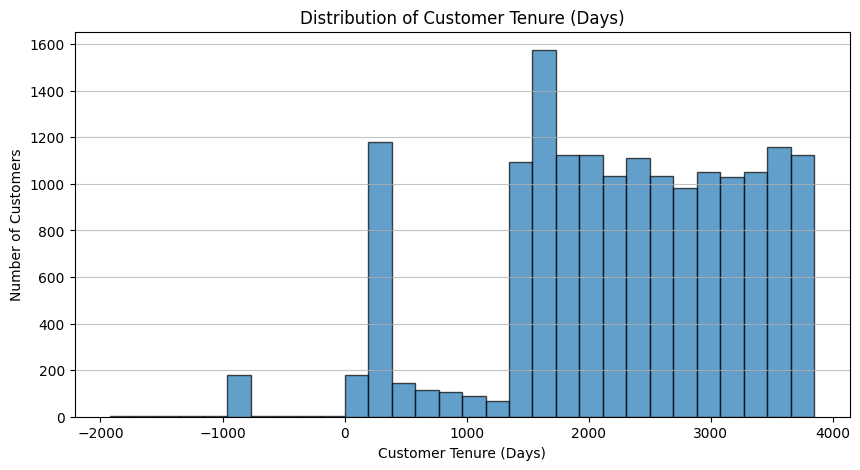

In [6]:
# Show histogram of CustomerTenureDays
plt.figure(figsize=(10,5))
plt.hist(customers["CustomerTenureDays"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Customer Tenure (Days)")
plt.xlabel("Customer Tenure (Days)")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
# Show the Values which are negative in Tenure Days
neg_tenure = customers[customers["CustomerTenureDays"] < 0]
print("Customers with negative tenure days:")
display(neg_tenure)

Customers with negative tenure days:


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,IsActive,EndDate,CustomerTenureDays
71,357549,Elisha,Furna,Elisha Furna,Canada,British Columbia,Whistler,50.116322,-122.957360,V6T 1Y8,...,60817.0,Single,Star,2021-09-21,2019-05-21,3964.73,Standard,0,2019-05-21,-854
76,265297,Ebonie,Radde,Ebonie Radde,Canada,Manitoba,Winnipeg,49.895138,-97.138374,R2C 0M5,...,39101.0,Married,Star,2021-07-17,2019-03-17,3978.67,Standard,0,2019-03-17,-853
172,845613,Jerald,Shiring,Jerald Shiring,Canada,Quebec,Montreal,45.501690,-73.567253,H2Y 4R4,...,30598.0,Married,Star,2021-10-13,2019-06-13,4198.03,Standard,0,2019-06-13,-853
205,830547,Dortha,Detar,Dortha Detar,Canada,British Columbia,Vancouver,49.282730,-123.120740,V5R 1W3,...,26245.0,Single,Star,2021-05-11,2019-01-11,4271.20,Standard,0,2019-01-11,-851
298,514900,Edith,Forslin,Edith Forslin,Canada,Ontario,Toronto,43.653225,-79.383186,P1L 8X8,...,80892.0,Married,Star,2021-07-20,2019-03-20,4425.91,Standard,0,2019-03-20,-853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16191,584796,Julieann,Mclaughlan,Julieann Mclaughlan,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,59853.0,Single,Star,2021-08-18,2019-04-18,19454.41,Standard,0,2019-04-18,-853
16199,774931,Cira,Defide,Cira Defide,Canada,British Columbia,Whistler,50.116322,-122.957360,V6T 1Y8,...,33588.0,Married,Star,2021-07-21,2019-03-21,19731.34,Standard,0,2019-03-21,-853
16228,275807,Arturo,Michaeli,Arturo Michaeli,Canada,Manitoba,Winnipeg,49.895138,-97.138374,R2C 0M5,...,71467.0,Divorced,Star,2021-10-18,2019-06-18,20446.60,Standard,0,2019-06-18,-853
16310,433307,Lyndon,Vogelgesang,Lyndon Vogelgesang,Canada,Manitoba,Winnipeg,49.895138,-97.138374,R2C 0M5,...,80540.0,Married,Star,2021-08-03,2019-04-03,22758.91,Standard,0,2019-04-03,-853


In [8]:
# Show the enrollment and cancellation dates of these customers to understand the issue
display(neg_tenure[["Loyalty#", "EnrollmentDateOpening", "CancellationDate", "CustomerTenureDays"]])

,Loyalty#,EnrollmentDateOpening,CancellationDate,CustomerTenureDays
71,357549,2021-09-21,2019-05-21,-854
76,265297,2021-07-17,2019-03-17,-853
172,845613,2021-10-13,2019-06-13,-853
205,830547,2021-05-11,2019-01-11,-851
298,514900,2021-07-20,2019-03-20,-853
...,...,...,...,...
16191,584796,2021-08-18,2019-04-18,-853
16199,774931,2021-07-21,2019-03-21,-853
16228,275807,2021-10-18,2019-06-18,-853
16310,433307,2021-08-03,2019-04-03,-853


In [9]:
# Delete the negative tenure rows from customers
#customers = customers[customers["CustomerTenureDays"] >= 0].copy()
#print("After removing negative tenure days:", customers.shape)

We can remove 200 customers, because they had negative tenure days which is not possible. This might be due to data entry errors or inconsistencies in the dataset. For now we will keep these rows as it is, but will delete it in further analysis.

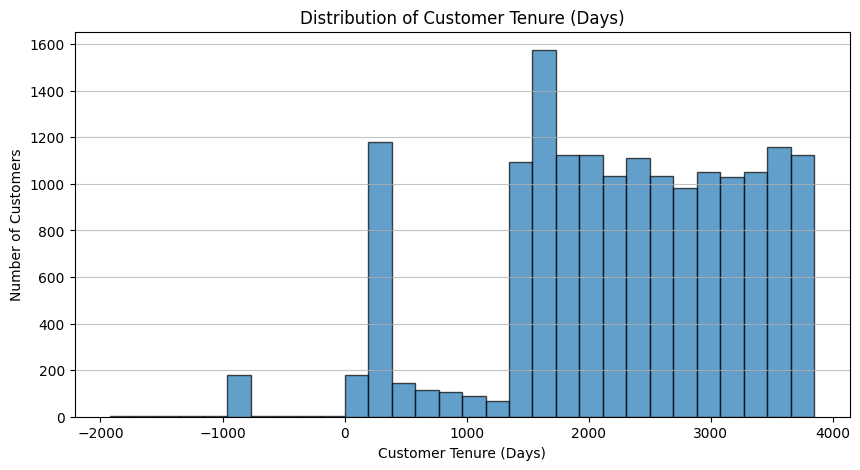

In [10]:
# Show histogram of CustomerTenureDays
plt.figure(figsize=(10,5))
plt.hist(customers["CustomerTenureDays"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Customer Tenure (Days)")
plt.xlabel("Customer Tenure (Days)")
plt.ylabel("Number of Customers")
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
# filter the dataset which had the longest tenure days
max_tenure = customers["CustomerTenureDays"].max()
longest_tenure_customers = customers[customers["CustomerTenureDays"] == max_tenure]
print(f"Customers with the longest tenure of {max_tenure} days:")
display(longest_tenure_customers)

Customers with the longest tenure of 3848 days:


,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,IsActive,EndDate,CustomerTenureDays
6173,597300,Scotty,Flecther,Scotty Flecther,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,52275.0,Married,Nova,2015-04-01,NaT,4982.68,Standard,1,2025-10-13,3848
7492,574745,Shanika,Puga,Shanika Puga,Canada,Quebec,Montreal,45.501690,-73.567253,H2Y 4R4,...,25318.0,Married,Nova,2015-04-01,NaT,7367.65,Standard,1,2025-10-13,3848
11788,654073,Darcy,Babine,Darcy Babine,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,71126.0,Married,Star,2015-04-01,NaT,2854.11,Standard,1,2025-10-13,3848


### Next step: Create a new data set containing the customer data with additional features from aggregated data from flights.



In [12]:
# Display Inconsistent Entries in Flights like NumFlights = 0 but DistanceKM > 0
inconsistent_flights = flights[(flights["NumFlights"] == 0) & (flights["DistanceKM"] > 0)]
print("Inconsistent entries in flights (NumFlights=0 but DistanceKM>0):")
display(inconsistent_flights)

Inconsistent entries in flights (NumFlights=0 but DistanceKM>0):


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed


In [13]:
# Maximum possible distance for a single flight (approx. Vancouver → Singapore)
max_km_per_flight = 13000  

# b) Threshold rule: flag rows where DistanceKM > NumFlights * 13,000
#    → i.e., total distance is unrealistically high given the number of flights
mask_threshold_bad = (
    flights["NumFlights"].notna() &  # only consider rows with valid NumFlights
    (flights["NumFlights"] > 0) &    # ignore entries with zero flights
    (flights["DistanceKM"] > flights["NumFlights"] * max_km_per_flight)
)

# Count and preview all entries exceeding 13,000 km per flight (suspiciously high)
print("Entries with DistanceKM > NumFlights * 13,000 km:", mask_threshold_bad.sum())

# Display first few suspicious rows for inspection
display(flights[mask_threshold_bad].head(3))


Entries with DistanceKM > NumFlights * 13,000 km: 0


,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed


In [14]:
# Show the flights of customer 100018
customer_100018_flights = flights[flights["Loyalty#"] == 100018]
# show the first 10 rows
display(customer_100018_flights.head(5))

,Loyalty#,Year,Month,YearMonthDate,NumFlights,NumFlightsWithCompanions,DistanceKM,PointsAccumulated,PointsRedeemed,DollarCostPointsRedeemed
18209,100018,2020,5,2020-05-01,0,0,0.0,0.0,0.0,0.0
33978,100018,2020,4,2020-04-01,4,0,6243.0,624.0,0.0,0.0
57755,100018,2020,3,2020-03-01,14,3,13706.0,1370.0,3468.0,34.0
64961,100018,2020,2,2020-02-01,2,2,9915.0,991.0,0.0,0.0
76848,100018,2020,1,2020-01-01,3,0,12300.0,1230.0,0.0,0.0


- We will add the aggregated data from flights to the customer data because it makes more sense. We would have too many duplicates if we add aggreagated data to flights.

In [15]:
# Check for decimals in flights NumFlights
has_decimals = flights["NumFlights"].isna().sum() == 0 and \
               not pd.Series(flights["NumFlights"].astype(int), dtype=int).equals(
                   flights["NumFlights"].astype(int)
               )
print("Are there decimals in NumFlights?", has_decimals)

Are there decimals in NumFlights? False


In [16]:
# Basic flight metrics per customer
flight_aggs = flights.groupby('Loyalty#').agg(
    # Aggregated Values
    total_flights=('NumFlights', 'sum'),
    total_flights_with_companions=('NumFlightsWithCompanions', 'sum'), 
    total_distance=('DistanceKM', 'sum'),
    total_points_accumulated=('PointsAccumulated', 'sum'),
    total_points_redeemed=('PointsRedeemed', 'sum'),
    total_cost_redeemed=('DollarCostPointsRedeemed', 'sum'),
).reset_index()

print("Flight aggregations summary:")

# Add derived metrics
flight_aggs['points_redemption_ratio'] = (
    flight_aggs['total_points_redeemed'] / 
    flight_aggs['total_points_accumulated'].replace(0, np.nan)
).fillna(0)

flight_aggs['companion_flight_ratio'] = (
    flight_aggs['total_flights_with_companions'] / 
    flight_aggs['total_flights']
).fillna(0)

display(flight_aggs.head())


Flight aggregations summary:


,Loyalty#,total_flights,total_flights_with_companions,total_distance,total_points_accumulated,total_points_redeemed,total_cost_redeemed,points_redemption_ratio,companion_flight_ratio
0,100018,225,45,530230.0,53014.30,20562.8,201.9,0.387873,0.200000
1,100102,245,55,339114.6,33903.96,18760.6,186.2,0.553345,0.224490
2,100140,218,51,432030.8,43192.58,4896.0,48.0,0.113353,0.233945
3,100214,144,17,364601.7,36453.77,12908.6,127.3,0.354109,0.118056
4,100272,202,50,429630.5,42953.25,10891.4,107.0,0.253564,0.247525


In [17]:
# print the first 3 rows of flight_aggs for debugging
display(flight_aggs.head(3))

,Loyalty#,total_flights,total_flights_with_companions,total_distance,total_points_accumulated,total_points_redeemed,total_cost_redeemed,points_redemption_ratio,companion_flight_ratio
0,100018,225,45,530230.0,53014.30,20562.8,201.9,0.387873,0.200000
1,100102,245,55,339114.6,33903.96,18760.6,186.2,0.553345,0.224490
2,100140,218,51,432030.8,43192.58,4896.0,48.0,0.113353,0.233945


In [18]:
# print the datatype of each column in flight_aggs
print("Data types in flight_aggs:")
print(flight_aggs.dtypes)

Data types in flight_aggs:
Loyalty#                           int64
total_flights                      int64
total_flights_with_companions      int64
total_distance                   float64
total_points_accumulated         float64
total_points_redeemed            float64
total_cost_redeemed              float64
points_redemption_ratio          float64
companion_flight_ratio           float64
dtype: object


In [19]:
# Add the aggregated data from flights to the customer data
customers = customers.merge(flight_aggs, on='Loyalty#', how='left')

# Show the first 5 rows of the updated customers dataframe
display(customers.head())

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,EndDate,CustomerTenureDays,total_flights,total_flights_with_companions,total_distance,total_points_accumulated,total_points_redeemed,total_cost_redeemed,points_redemption_ratio,companion_flight_ratio
0,480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,...,2025-10-13,2432,216,53,507054.9,50699.39,13517.9,134.6,0.266628,0.245370
1,549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,...,2025-10-13,2410,286,30,426827.4,42672.54,22457.8,221.4,0.526282,0.104895
2,429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,...,2021-01-08,1274,143,37,238376.1,23832.41,5479.6,53.2,0.229922,0.258741
3,608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,...,2025-10-13,3526,198,55,386029.3,38595.63,16331.5,162.2,0.423144,0.277778
4,530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,...,2025-10-13,2910,201,59,369242.6,36916.56,0.0,0.0,0.000000,0.293532


In [20]:
# Export the data
customers.to_csv(out_dir / "customers_aggregations.csv", index=False)